# Imports

In [8]:
!pip install ultralytics
!pip install roboflow
!pip install opencv-python matplotlib

In [9]:
import os
import time
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from google.colab import files
import torch

In [10]:
# Check GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of GPUs: {device_count}")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found. Will use CPU instead.")

# Set device
device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

GPU available: True
Number of GPUs: 1
GPU 0: Tesla T4
Using device: 0


# Dataset Download Section

In [11]:
rf = Roboflow(api_key="OOMi0m3PhpE0bSmlr5rx")
project = rf.workspace("luigui-andre-cerna-grados-dpsrr").project("clasificacion-de-mangos")
version = project.version(16)

# Retry mechanism with error handling
retries = 3
for attempt in range(retries):
    try:
        dataset = version.download("yolov12")
        break  # Exit loop if successful
    except ConnectionError as e:
        print(f"Download attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print(f"Retrying in 5 seconds...")
            time.sleep(5)  # Wait before retrying
        else:
            print("Maximum retries reached. Download failed.")
            raise  # Re-raise the exception after max retries

# Rename the dataset folder to a more manageable name
!mv "/content/Clasificación-de-mangos-16" "/content/mango_dataset"

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Clasificación-de-mangos-16 in yolov12:: 100%|██████████| 4004/4004 [00:01<00:00, 2499.83it/s]


mv: cannot move '/content/Clasificación-de-mangos-16' to '/content/mango_dataset/Clasificación-de-mangos-16': Directory not empty


# Data Preprocessing Section

Starting dataset preprocessing...
Training set: 1529 images
Validation set: 65 images


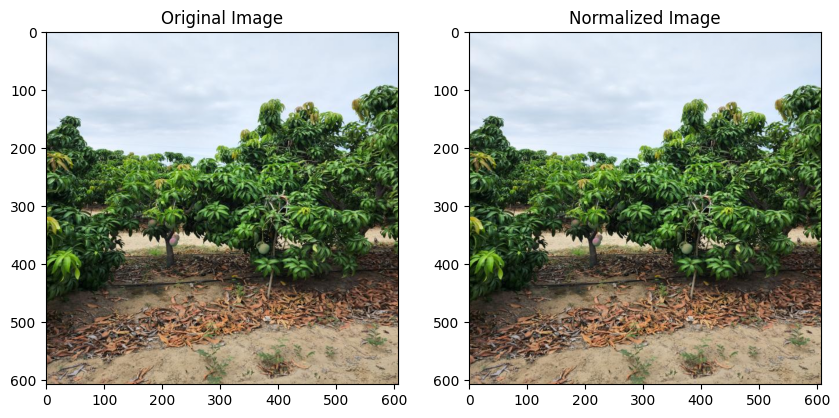

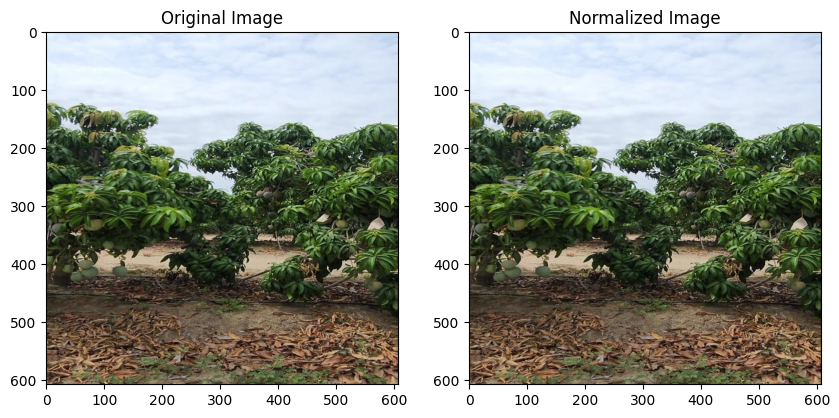

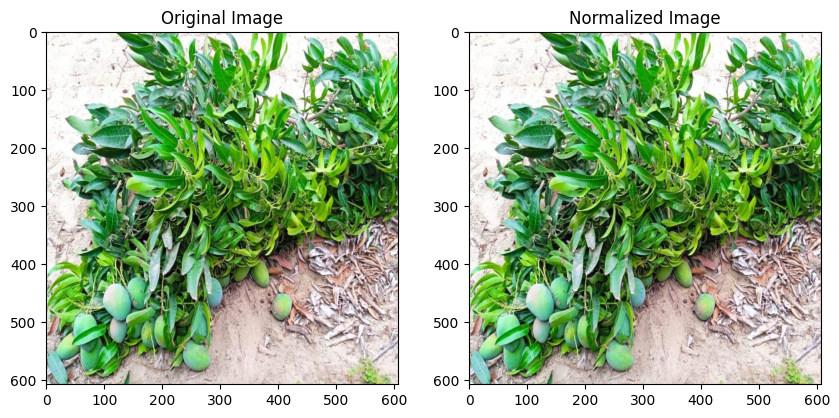

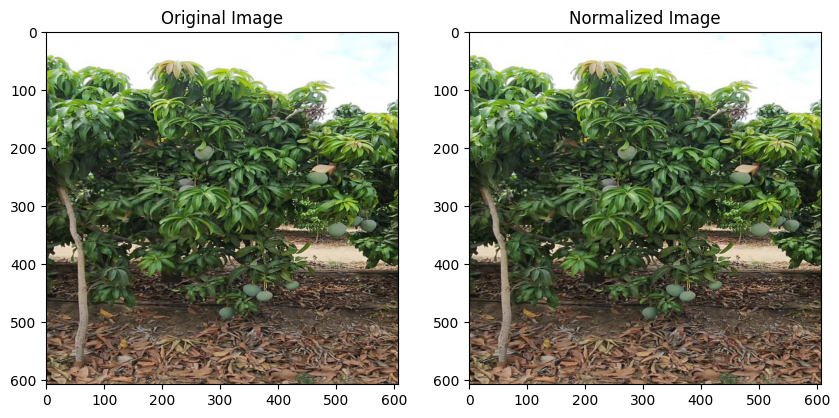

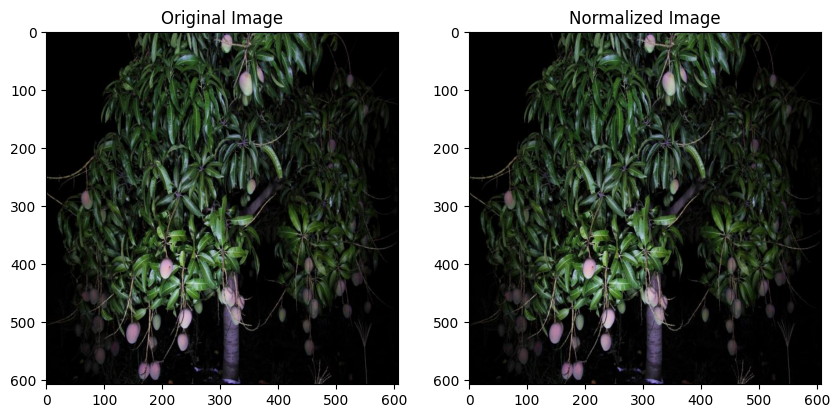

Dataset YAML configuration:

train: /content/mango_dataset/train/images
val: /content/mango_dataset/valid/images
test: /content/mango_dataset/test/images

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
        
Dataset preprocessing completed!


In [12]:
def preprocess_dataset(base_path):
    """
    Preprocess the dataset images to enhance training
    - Apply image normalization
    - Apply image augmentation
    - Check and report dataset statistics
    """
    print("Starting dataset preprocessing...")

    # Set paths
    train_path = os.path.join(base_path, 'train', 'images')
    val_path = os.path.join(base_path, 'valid', 'images')

    # Count datasets and analyze
    train_files = os.listdir(train_path)
    val_files = os.listdir(val_path)

    print(f"Training set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")

    # Sample preprocessing on a few images to test
    sample_images = train_files[:5]  # Process first 5 images as a sample

    for img_file in sample_images:
        img_path = os.path.join(train_path, img_file)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading image {img_file}")
            continue

        # Convert BGR to RGB (OpenCV loads as BGR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize image
        img_norm = img_rgb / 255.0

        # Display original and preprocessed image for verification
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(img_rgb)

        plt.subplot(1, 2, 2)
        plt.title("Normalized Image")
        plt.imshow(img_norm)
        plt.show()

    # Validate dataset YAML file
    with open(os.path.join(base_path, 'data.yaml'), 'r') as f:
        yaml_content = f.read()
        print("Dataset YAML configuration:")
        print(yaml_content)

    # Create a modified YAML file for Ultralytics
    with open(os.path.join(base_path, 'data.yaml'), 'w') as f:
        f.write(f"""
train: {train_path}
val: {val_path}
test: {os.path.join(base_path, 'test', 'images')}

nc: 1
names: ['Mango']

roboflow:
  workspace: luigui-andre-cerna-grados-dpsrr
  project: clasificacion-de-mangos
  version: 16
  license: CC BY 4.0
  url: https://universe.roboflow.com/luigui-andre-cerna-grados-dpsrr/clasificacion-de-mangos/dataset/16
        """)

    print("Dataset preprocessing completed!")
    return os.path.join(base_path, 'data.yaml')

# Execute preprocessing
yaml_path = preprocess_dataset('/content/mango_dataset')

# Model Training

Starting model training with YOLOv8 on device: 0...


100%|██████████| 49.7M/49.7M [00:00<00:00, 244MB/s]


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/mango_dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=mango_detector_v8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

100%|██████████| 755k/755k [00:00<00:00, 23.8MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192,

100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1165.8±555.8 MB/s, size: 85.7 KB)


train: Scanning /content/mango_dataset/train/labels... 1529 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1529/1529 [00:00<00:00, 1671.13it/s]


train: New cache created: /content/mango_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 745.1±475.1 MB/s, size: 66.1 KB)


val: Scanning /content/mango_dataset/valid/labels... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<00:00, 902.64it/s]

val: New cache created: /content/mango_dataset/valid/labels.cache


Plotting labels to runs/detect/mango_detector_v8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/mango_detector_v8
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.21G      1.415      1.121     0.9927        288        640: 100%|██████████| 96/96 [00:56<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


                   all         65        649      0.704      0.612      0.648      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.96G       1.38     0.7922     0.9671        185        640: 100%|██████████| 96/96 [00:52<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         65        649      0.131      0.596     0.0952     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.32G      1.388     0.7901      0.966        368        640: 100%|██████████| 96/96 [00:55<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         65        649      0.835      0.724      0.792      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       7.1G      1.361     0.7615     0.9637        253        640: 100%|██████████| 96/96 [00:54<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         65        649      0.848        0.8      0.852      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.66G      1.337     0.7346     0.9519        239        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         65        649      0.869      0.743      0.842      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.37G      1.319     0.7121     0.9436        276        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         65        649      0.888      0.755      0.855      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.16G      1.311     0.7112     0.9487        204        640: 100%|██████████| 96/96 [00:54<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         65        649      0.852      0.781      0.866      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.03G      1.294     0.6972     0.9375        447        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         65        649      0.884      0.777      0.872      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.11G      1.284     0.6905     0.9345        307        640: 100%|██████████| 96/96 [00:54<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         65        649      0.891      0.816      0.882      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.01G      1.267     0.6704     0.9302        658        640: 100%|██████████| 96/96 [00:54<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         65        649      0.822       0.82      0.859      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.78G      1.266     0.6677      0.926        472        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         65        649      0.882      0.816      0.874      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.38G      1.242     0.6429      0.925        181        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         65        649       0.86      0.817      0.886      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.55G      1.238     0.6505     0.9277        312        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all         65        649      0.862      0.838      0.888      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.79G       1.23     0.6387     0.9238        323        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         65        649        0.9      0.801      0.885      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.94G      1.222     0.6247     0.9191        268        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         65        649      0.913      0.814      0.893      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.36G      1.222       0.62     0.9173        321        640: 100%|██████████| 96/96 [00:53<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         65        649       0.91       0.81      0.895      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.55G      1.202     0.6051     0.9138        364        640: 100%|██████████| 96/96 [00:54<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         65        649      0.888      0.849      0.909       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.57G      1.193     0.6007     0.9121        185        640: 100%|██████████| 96/96 [00:53<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         65        649      0.901      0.842      0.908      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.62G      1.197     0.6011     0.9073        359        640: 100%|██████████| 96/96 [00:54<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         65        649      0.886      0.851      0.905      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.17G      1.193     0.5999      0.913        300        640: 100%|██████████| 96/96 [00:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         65        649      0.889      0.849      0.904       0.61


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.31G      1.169      0.585      0.911        284        640: 100%|██████████| 96/96 [00:53<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         65        649      0.922      0.818      0.901      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.32G      1.162     0.5733      0.913        311        640: 100%|██████████| 96/96 [00:52<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         65        649      0.892      0.854      0.908      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       6.3G      1.156     0.5738      0.914        192        640: 100%|██████████| 96/96 [00:52<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         65        649      0.884      0.846      0.899      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.26G      1.143     0.5577     0.9092        264        640: 100%|██████████| 96/96 [00:52<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         65        649      0.885      0.846      0.902      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       6.5G       1.14     0.5522     0.9047        146        640: 100%|██████████| 96/96 [00:53<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         65        649      0.916      0.823      0.901      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.37G      1.124     0.5396      0.904        195        640: 100%|██████████| 96/96 [00:52<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         65        649      0.894      0.857      0.909      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.27G      1.108     0.5272     0.8987        179        640: 100%|██████████| 96/96 [00:52<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         65        649      0.901      0.846      0.905      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       6.3G       1.11     0.5225     0.8956        231        640: 100%|██████████| 96/96 [00:52<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         65        649      0.906      0.848      0.908      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       6.5G      1.098     0.5139      0.892        173        640: 100%|██████████| 96/96 [00:53<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         65        649      0.895      0.854      0.911       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.29G      1.082     0.5024     0.8909        257        640: 100%|██████████| 96/96 [00:52<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         65        649      0.903      0.852      0.907      0.642



30 epochs completed in 0.490 hours.
Optimizer stripped from runs/detect/mango_detector_v8/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/mango_detector_v8/weights/best.pt, 52.0MB

Validating runs/detect/mango_detector_v8/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


                   all         65        649      0.902      0.853      0.907      0.642
Speed: 0.2ms preprocess, 10.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/mango_detector_v8
Model trained and saved to /content/mango_detector_v8.pt

Training Results:
metrics/precision(B): 0.9021723901234611
metrics/recall(B): 0.8525795721481392
metrics/mAP50(B): 0.9066105219353283
metrics/mAP50-95(B): 0.641577726680659
fitness: 0.668081006206126


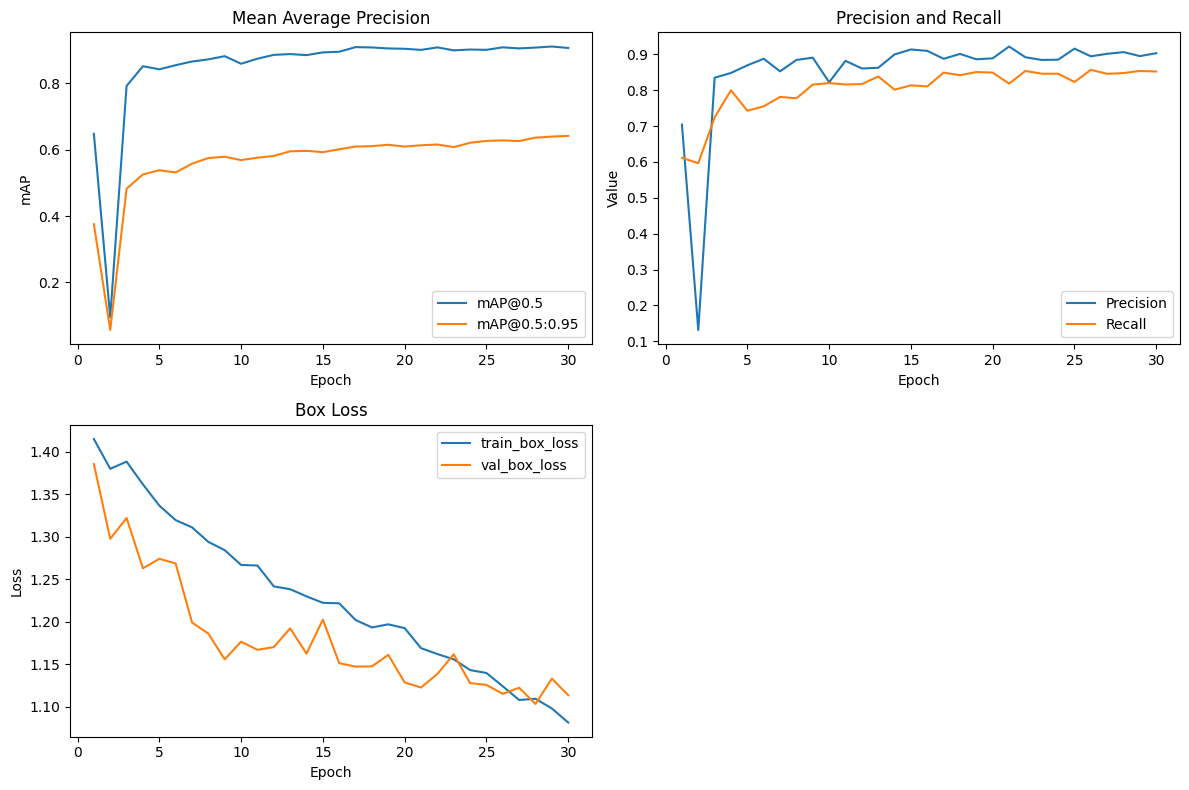

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
def train_model(dataset_yaml, epochs=50, image_size=640, batch_size=16, device=0):
    """
    Train the YOLOv8 model
    """
    print(f"Starting model training with YOLOv8 on device: {device}...")

    model = YOLO('yolov8m.pt')

    # Train the model
    results = model.train(
        data=dataset_yaml,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        name='mango_detector_v8',
        device=device,
        verbose=True
    )

    model_path = '/content/mango_detector_v8.pt'
    best_weights_path = os.path.join(model.trainer.save_dir, 'weights', 'best.pt')

    # Copy best weights to desired path
    if os.path.exists(best_weights_path):
        os.system(f"cp {best_weights_path} {model_path}")
        print(f"Model trained and saved to {model_path}")
    else:
        print(f"Best weights not found at {best_weights_path}")
        alt_path = os.path.join(model.trainer.save_dir, 'weights', 'last.pt')
        if os.path.exists(alt_path):
            os.system(f"cp {alt_path} {model_path}")
            print(f"Last checkpoint saved to {model_path}")
        else:
            print("Could not find model weights to save.")

    # Display training results
    results_dict = results.results_dict if hasattr(results, 'results_dict') else {}
    print("\nTraining Results:")
    for metric, value in results_dict.items():
        print(f"{metric}: {value}")

    # Plot training curves
    try:
        results_csv = os.path.join(model.trainer.save_dir, 'results.csv')
        if os.path.exists(results_csv):
            df = pd.read_csv(results_csv)

            plt.figure(figsize=(12, 8))

            # mAP
            plt.subplot(2, 2, 1)
            plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
            plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
            plt.title('Mean Average Precision')
            plt.xlabel('Epoch')
            plt.ylabel('mAP')
            plt.legend()

            # Precision and Recall
            plt.subplot(2, 2, 2)
            plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
            plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
            plt.title('Precision and Recall')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()

            # Losses
            plt.subplot(2, 2, 3)
            plt.plot(df['epoch'], df['train/box_loss'], label='train_box_loss')
            plt.plot(df['epoch'], df['val/box_loss'], label='val_box_loss')
            plt.title('Box Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting metrics: {e}")

    return model, model_path

# Train the model
try:
    model, model_path = train_model(yaml_path, epochs=30, device=device)
    files.download(model_path)
except Exception as e:
    print(f"Error during training: {e}")
    model_path = '/content/runs/detect/train/weights/best.pt'
    print(f"Using fallback path: {model_path}")

# Metrics

Evaluating model metrics on device: 0...
Successfully loaded model from /content/mango_detector_v8.pt
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1411.6±575.5 MB/s, size: 66.4 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


                   all         65        649      0.905      0.853      0.909      0.642
Speed: 9.3ms preprocess, 26.4ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/detect/val
Validation completed successfully in 7.34 seconds

===== Detection Metrics Summary =====
mAP@0.5: 0.9087
mAP@0.5:0.95: 0.6425
Precision: 0.9052
Recall: 0.8534
F1-Score: 0.8785
Time taken: 7.34 seconds


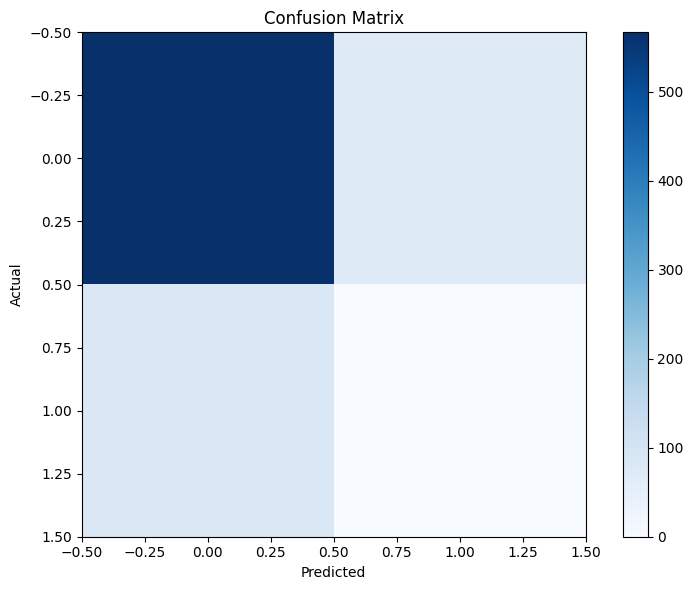


Evaluating on test set (defined in YAML)...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2461.8±710.1 MB/s, size: 76.2 KB)


val: Scanning /content/mango_dataset/valid/labels.cache... 65 images, 0 backgrounds, 0 corrupt: 100%|██████████| 65/65 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


                   all         65        649      0.905      0.853      0.909      0.642
Speed: 4.8ms preprocess, 24.4ms inference, 0.1ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val2

===== Final Detection Metrics =====
Precision: 0.9052
Recall: 0.8534
F1-Score: 0.8785
mAP@0.5: 0.9087
mAP@0.5:0.95: 0.6425
mAP@0.75: 0.7738
Time taken on test set: 6.42 seconds


In [14]:
def check_model_metrics(model_path, yaml_path, device=0):
    """
    Check and visualize metrics for the trained model
    """
    print(f"Evaluating model metrics on device: {device}...")

    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}. Looking for alternative paths...")
        alt_paths = [
            '/content/runs/detect/mango_detector/weights/best.pt',
            '/content/runs/detect/mango_detector/weights/last.pt',
            '/content/runs/detect/train/weights/best.pt'
        ]
        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                model_path = alt_path
                print(f"Found model at alternative path: {model_path}")
                break
        else:
            print("No model found. Cannot evaluate metrics.")
            return None

    # Load the trained model
    try:
        model = YOLO(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

    # Time the validation
    try:
        start_time = time.time()
        results = model.val(data=yaml_path, device=device)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Validation completed successfully in {elapsed_time:.2f} seconds")
    except Exception as e:
        print(f"Error during validation: {e}")
        return None

    # Print metrics summary
    metrics = results.box
    print("\n===== Detection Metrics Summary =====")
    print(f"mAP@0.5: {metrics.map50:.4f}")
    print(f"mAP@0.5:0.95: {metrics.map:.4f}")
    print(f"Precision: {metrics.p[0]:.4f}")
    print(f"Recall: {metrics.r[0]:.4f}")
    print(f"F1-Score: {metrics.f1[0]:.4f}")
    print(f"Time taken: {elapsed_time:.2f} seconds")

    # Confusion matrix plot
    try:
        if hasattr(results, 'confusion_matrix') and results.confusion_matrix is not None:
            conf_matrix = results.confusion_matrix.matrix
            plt.figure(figsize=(8, 6))
            plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.colorbar()
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")

    return results

# Call the function with model and dataset paths
if 'model_path' in locals():
    model_metrics = check_model_metrics(model_path, yaml_path, device=device)

    # Display metrics on test set specifically
    print("\nEvaluating on test set (defined in YAML)...")
    try:
        model = YOLO(model_path)
        start_time = time.time()
        test_results = model.val(data=yaml_path, device=device, split='val')
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Print full metrics summary from test results
        metrics = test_results.box
        print("\n===== Final Detection Metrics =====")
        print(f"Precision: {metrics.p[0]:.4f}")
        print(f"Recall: {metrics.r[0]:.4f}")
        print(f"F1-Score: {metrics.f1[0]:.4f}")
        print(f"mAP@0.5: {metrics.map50:.4f}")
        print(f"mAP@0.5:0.95: {metrics.map:.4f}")
        print(f"mAP@0.75: {metrics.map75:.4f}")
        print(f"Time taken on test set: {elapsed_time:.2f} seconds")

    except Exception as e:
        print(f"Error evaluating on test set: {e}")
else:
    print("No model path defined. Skipping metrics check.")

# Model Inference

Upload an image for inference:


Saving WhatsApp Image 2025-04-21 at 16.26.08_5257b426.png.jpg to WhatsApp Image 2025-04-21 at 16.26.08_5257b426.png.jpg
Successfully loaded model from /content/mango_detector_v8.pt

image 1/1 /content/WhatsApp Image 2025-04-21 at 16.26.08_5257b426.png.jpg: 448x640 11 Mangos, 42.0ms
Speed: 2.6ms preprocess, 42.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict
Inference completed successfully
Found 11 mangoes in the image
Detected Mango with confidence 0.91
Detected Mango with confidence 0.88
Detected Mango with confidence 0.87
Detected Mango with confidence 0.87
Detected Mango with confidence 0.86
Detected Mango with confidence 0.86
Detected Mango with confidence 0.86
Detected Mango with confidence 0.85
Detected Mango with confidence 0.76
Detected Mango with confidence 0.52
Detected Mango with confidence 0.50


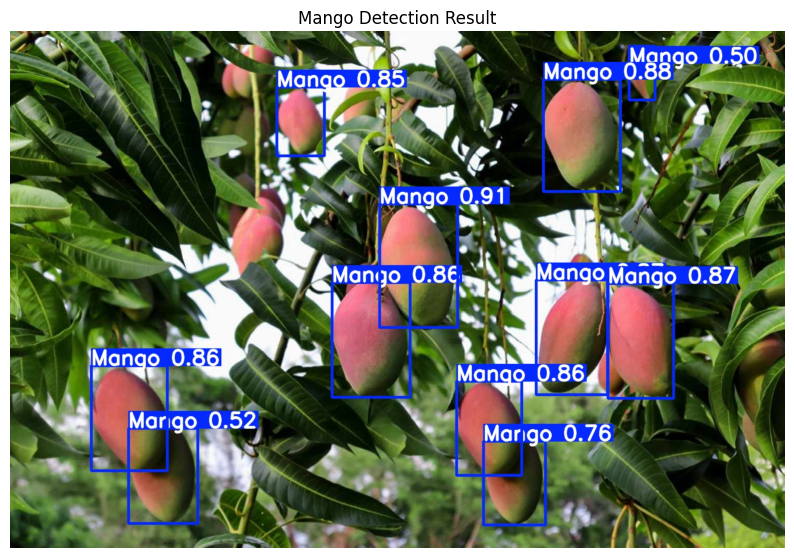

In [15]:
def inference_on_image(model_path, device=0):
    """
    Perform inference on uploaded images using GPU
    """
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}. Looking for alternative paths...")
        # Try to find the model in possible alternative locations
        alt_paths = [
            '/content/runs/detect/mango_detector/weights/best.pt',
            '/content/runs/detect/mango_detector/weights/last.pt',
            '/content/runs/detect/train/weights/best.pt'
        ]

        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                model_path = alt_path
                print(f"Found model at alternative path: {model_path}")
                break
        else:
            print("No model found. Cannot perform inference.")
            return

    print("Upload an image for inference:")
    uploaded = files.upload()  # Prompt to upload an image

    if not uploaded:
        print("No image uploaded!")
        return

    uploaded_file = list(uploaded.keys())[0]

    # Load model
    try:
        model = YOLO(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Run inference with GPU
    try:
        results = model.predict(
            source=uploaded_file,
            conf=0.5,
            save=True,
            device=device
        )
        print("Inference completed successfully")
    except Exception as e:
        print(f"Error during inference: {e}")
        return

    # Display results
    for r in results:
        # Plot detection results
        boxes = r.boxes
        print(f"Found {len(boxes)} mangoes in the image")

        # Display detection details
        for box in boxes:
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())
            cls_name = model.names[cls]
            print(f"Detected {cls_name} with confidence {conf:.2f}")

    # Show the prediction image
    try:
        # Get the latest predict folder (sorted by creation time)
        predict_dirs = [d for d in os.listdir('runs/detect') if d.startswith('predict')]
        if predict_dirs:
            newest_dir = max(predict_dirs, key=lambda x: os.path.getctime(os.path.join('runs/detect', x)))
            result_image_path = os.path.join('runs', 'detect', newest_dir, uploaded_file)

            if os.path.exists(result_image_path):
                img = cv2.imread(result_image_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(10, 8))
                plt.title("Mango Detection Result")
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.show()
            else:
                print(f"Result image not found at {result_image_path}")
        else:
            print("No prediction directory found")
    except Exception as e:
        print(f"Error displaying result image: {e}")

# Run inference with the trained model
if 'model_path' in locals():
    try:
        inference_on_image(model_path, device=device)
    except Exception as e:
        print(f"Error during inference: {e}")
else:
    print("No model path defined. Skipping inference.")